## Project Goal: Predict 2026 Box Office Top 10

**Objective**: Predict the top 10 highest-grossing movies for 2026 domestic box office

**Approach**: 
1. Train regression models to predict `revenue_domestic` 
2. Rank predictions to identify top 10 movies
3. Use temporal validation: Train (2015-2023), Validate (2024), Test (2025)

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Load the processed dataset
df = pd.read_csv('../data/dataset_domestic_processed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"Average revenue: ${df['revenue_domestic'].mean():,.0f}")

# Display basic info
print(f"\nRevenue distribution by year:")
yearly_stats = df.groupby('release_year')['revenue_domestic'].agg(['count', 'mean', 'median', 'max']).round(0)
print(yearly_stats)

Dataset shape: (1531, 89)
Date range: 2015-2025
Revenue range: $521,202 - $936,662,225
Average revenue: $60,442,440

Revenue distribution by year:
              count        mean      median          max
release_year                                            
2015            162  69763290.0  32835598.0  936662225.0
2016            168  66825587.0  34630180.0  533539991.0
2017            167  66625481.0  30014539.0  620181382.0
2018            174  64657671.0  30721012.0  700426566.0
2019            162  73721708.0  40860481.0  858373000.0
2020             56  23316848.0   9613273.0  206305244.0
2021             99  46898910.0  17318007.0  814866759.0
2022            114  66987846.0  19431476.0  718732821.0
2023            138  58680472.0  19279704.0  636238421.0
2024            172  49260881.0   9002073.0  652980194.0
2025            119  46496565.0  15683090.0  423949195.0


In [3]:
df

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,release_year,genres,title_normalized,domestic_revenue,rank,distributor,revenue_domestic,revenue,is_disney,is_warner_bros,is_universal,is_sony,is_paramount,is_fox,is_mgm,is_lionsgate,is_major_studio,genre_names,genre_drama,genre_comedy,genre_thriller,genre_action,genre_adventure,genre_horror,genre_science_fiction,genre_family,genre_crime,genre_fantasy,genre_romance,genre_mystery,genre_history,genre_animation,genre_music,genre_war,genre_western,is_action_adventure,is_action_sci_fi,is_comedy_romance,is_family_animation,primary_genre,genre_count,release_month,release_month_name,release_season,is_summer_blockbuster,is_holiday_release,is_oscar_season,is_holiday_proximity,nearest_holiday,days_to_holiday,is_christmas_proximity,is_thanksgiving_proximity,is_independence_day_proximity,is_memorial_labor_day_proximity,has_nearby_major_release,nearby_major_releases_count,nearby_major_releases_max_revenue,days_to_nearest_major_release,competition_intensity,has_blockbuster_competition,has_immediate_competition,is_sequel_title,is_marvel,is_dc,is_star_wars,is_fast_furious,is_harry_potter,is_franchise_sequel,is_sequel,is_live_action_remake,is_adaptation,is_superhero,has_remake_indicator,is_remake_adaptation,is_ip_movie
0,False,/aan0KdhVgJfAwUJ3n2HDFOWcxZ2.jpg,[35],252838,en,The Wedding Ringer,Doug Harris is a loveable but socially awkward...,3.1703,/ciR2suRkfJen9lQvfz22lgCj7g7.jpg,2015-01-16,The Wedding Ringer,False,6.460,1625,2015,[35],The Wedding Ringer,64460211.0,1449.0,Screen Gems,64460211.0,64460211.0,0,0,0,1,0,0,0,0,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,0,0,0,NaN,Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,False,/1u7TuvR5mSUz2xRQhz01i75IwdT.jpg,"[80, 53, 28]",201088,en,Blackhat,"Nicholas Hathaway, a furloughed convict, and h...",9.5554,/7zu6HPnKPjNA7NuR4DGRdaH0PdX.jpg,2015-01-16,Blackhat,False,5.512,2095,2015,"[80, 53, 28]",Blackhat,8005980.0,5583.0,Universal Pictures,8005980.0,8005980.0,0,0,1,0,0,0,0,0,1,"Crime,Thriller,Action",0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Crime,3,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,1,1,64460211,0.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,False,/aUbyQhWcPS7S0Su2d9Tgk3NxdPk.jpg,"[10402, 16, 10751, 14]",302429,en,Strange Magic,A love potion works its devious charms on fair...,4.4907,/vjCdrK8gGRFnyuZb1j9BzgN2RaY.jpg,2015-01-23,Strange Magic,False,7.200,526,2015,"[10402, 16, 10751, 14]",Strange Magic,12429583.0,4831.0,Walt Disney Studios Motion Pictures,12429583.0,12429583.0,1,0,0,0,0,0,0,0,1,"Music,Animation,Family,Fantasy",0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,Music,4,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,False,/6Sg4UUs0OksCbR0TZxUtQWPOMDV.jpg,"[35, 12]",210860,en,Mortdecai,"An art dealer, Charles Mortdecai, searches for...",4.1565,/zIRDhdAuMevOuY2vs3s1HNcqDq7.jpg,2015-01-23,Mortdecai,False,5.500,2688,2015,"[35, 12]",Mortdecai,7696134.0,5640.0,Lionsgate,7696134.0,7696134.0,0,0,0,0,0,0,0,1,1,"Comedy,Adventure",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,2,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,False,/96iXwJibeNW9RGEa58zYa0SQV6m.jpg,[53],241251,en,The Boy Next Door,A recently cheated on married woman falls for ...,3.5103,/gicmSeLG6Uh7BF1r1mxZHUQ8r26.jpg,2015-01-23,The Boy Next Door,False,4.900,2067,2015,[53],The Boy Next Door,35423380.0,2624.0,Universal Pictures,35423380.0,35423380.0,0,0,1,0,0,0,0,0,1,Thriller,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thriller,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [4]:
# Define feature columns (exclude metadata and target)
exclude_cols = [
    # Metadata columns
    'adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 
    'overview', 'poster_path', 'release_date', 'title', 'video', 'genres', 
    'title_normalized', 'rank', 'distributor', 'genre_names', 'release_month_name',
    'nearest_holiday', 'nearby_major_releases_max_revenue', 'days_to_nearest_major_release',
    
    # Target variables
    'domestic_revenue', 'revenue_domestic', 'revenue',
    
    # String/categorical columns that need special handling
    'primary_genre', 'release_season', 'competition_intensity',
    
    # TMDb post-release features (potential data leakage)
    'popularity', 'vote_average', 'vote_count'
]

# Get all columns first
all_cols = df.columns.tolist()

# Get potential feature columns
potential_features = [col for col in all_cols if col not in exclude_cols]

# Only keep numeric columns for baseline models
numeric_features = []
for col in potential_features:
    if df[col].dtype in ['int64', 'float64', 'bool', 'int32', 'float32']:
        numeric_features.append(col)
    elif df[col].dtype == 'object':
        # Check if it's binary string (like 'True'/'False' or '0'/'1')
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 2:
            print(f"Including binary-like string column: {col} (values: {unique_vals})")
            numeric_features.append(col)
        else:
            print(f"Excluding string column: {col} (values: {unique_vals[:5]}...)")

feature_cols = numeric_features

print(f"Number of numeric features: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")

# Target variable
target = 'revenue_domestic'

print(f"\nTarget variable: {target}")
print(f"Missing values in target: {df[target].isnull().sum()}")

# Check for missing values in features
missing_features = df[feature_cols].isnull().sum()
features_with_missing = missing_features[missing_features > 0]
if len(features_with_missing) > 0:
    print(f"Features with missing values:")
    print(features_with_missing)
else:
    print(f"No missing values in features ✅")

Number of numeric features: 60
First 10 features: ['release_year', 'is_disney', 'is_warner_bros', 'is_universal', 'is_sony', 'is_paramount', 'is_fox', 'is_mgm', 'is_lionsgate', 'is_major_studio']

Target variable: revenue_domestic
Missing values in target: 0
Features with missing values:
days_to_holiday    797
dtype: int64


In [5]:
# Analyze major studio dominance
print("🏢 Major Studio Analysis")
print("=" * 40)

# Overall major studio distribution
major_studio_dist = df['is_major_studio'].value_counts()
print(f"Overall distribution:")
print(f"  Major Studios: {major_studio_dist[1]:,} movies ({major_studio_dist[1]/len(df)*100:.1f}%)")
print(f"  Independent:   {major_studio_dist[0]:,} movies ({major_studio_dist[0]/len(df)*100:.1f}%)")

# Revenue comparison
major_studio_revenue = df.groupby('is_major_studio')['revenue_domestic'].agg(['count', 'mean', 'median', 'max'])
print(f"\nRevenue by studio type:")
print(major_studio_revenue)

# Top 10 each year analysis
print(f"\nTop 10 movies per year - Major Studio percentage:")
for year in range(2015, 2026):
    if year in df['release_year'].values:
        top10_year = df[df['release_year'] == year].nlargest(10, 'revenue_domestic')
        major_pct = top10_year['is_major_studio'].mean() * 100
        print(f"  {year}: {major_pct:.0f}% major studio")

# Top 50 all-time analysis
top50_alltime = df.nlargest(50, 'revenue_domestic')
top50_major_pct = top50_alltime['is_major_studio'].mean() * 100
print(f"\nTop 50 all-time movies: {top50_major_pct:.0f}% major studio")

# Revenue distribution within major studios
major_only = df[df['is_major_studio'] == 1]
print(f"\nWithin major studios:")
print(f"  Movies: {len(major_only):,}")
print(f"  Revenue range: ${major_only['revenue_domestic'].min():,.0f} - ${major_only['revenue_domestic'].max():,.0f}")
print(f"  Average: ${major_only['revenue_domestic'].mean():,.0f}")
print(f"  Std Dev: ${major_only['revenue_domestic'].std():,.0f}")

# Independent film analysis  
indie_only = df[df['is_major_studio'] == 0]
print(f"\nWithin independent films:")
print(f"  Movies: {len(indie_only):,}")
print(f"  Revenue range: ${indie_only['revenue_domestic'].min():,.0f} - ${indie_only['revenue_domestic'].max():,.0f}")
print(f"  Average: ${indie_only['revenue_domestic'].mean():,.0f}")
print(f"  Max (highest indie): ${indie_only['revenue_domestic'].max():,.0f}")
print(f"  Top indie film: {indie_only.loc[indie_only['revenue_domestic'].idxmax(), 'title']}")

🏢 Major Studio Analysis
Overall distribution:
  Major Studios: 890 movies (58.1%)
  Independent:   641 movies (41.9%)

Revenue by studio type:
                 count          mean      median          max
is_major_studio                                              
0                  641  1.175686e+07   4178620.0  184178046.0
1                  890  9.550700e+07  52281546.5  936662225.0

Top 10 movies per year - Major Studio percentage:
  2015: 100% major studio
  2016: 100% major studio
  2017: 100% major studio
  2018: 100% major studio
  2019: 100% major studio
  2020: 100% major studio
  2021: 100% major studio
  2022: 100% major studio
  2023: 90% major studio
  2024: 100% major studio
  2025: 100% major studio

Top 50 all-time movies: 100% major studio

Within major studios:
  Movies: 890
  Revenue range: $521,202 - $936,662,225
  Average: $95,506,997
  Std Dev: $123,728,111

Within independent films:
  Movies: 641
  Revenue range: $521,396 - $184,178,046
  Average: $11,756,863


### Strategic Decision: How to Handle Major Studio Dominance?

Based on the analysis above, we have two options for improving our model:

In [6]:
# STRATEGIC DECISION: Focus on Major Studio Films Only
print("🎯 FOCUSING ON MAJOR STUDIO FILMS ONLY")
print("=" * 50)
print("Rationale: The 2026 top 10 will almost certainly be all major studio films")
print("This allows us to focus on what differentiates successful major releases")

# Filter all data to only major studios
df_major_only = df[df['is_major_studio'] == 1].copy()
print(f"\nDataset filtering:")
print(f"  Original dataset: {len(df):,} movies")
print(f"  Major studio only: {len(df_major_only):,} movies ({len(df_major_only)/len(df)*100:.1f}%)")

# Remove is_major_studio from features (since all are now major studios)
feature_cols_focused = [col for col in feature_cols if col != 'is_major_studio']

# Update dataframe and feature columns
df = df_major_only
feature_cols = feature_cols_focused

print(f"\nFeature engineering:")
print(f"  Removed is_major_studio feature (now constant)")
print(f"  Updated feature count: {len(feature_cols)}")
print(f"  Kept individual studio flags (Disney, Universal, etc.) for studio-specific insights")

print(f"\nMajor studio dataset statistics:")
print(f"  Movies: {len(df):,}")
print(f"  Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"  Average revenue: ${df['revenue_domestic'].mean():,.0f}")
print(f"  Revenue std dev: ${df['revenue_domestic'].std():,.0f}")

# Show year distribution
year_counts = df.groupby('release_year').size()
print(f"\nMajor studio movies by year:")
for year in sorted(year_counts.index):
    print(f"  {year}: {year_counts[year]} movies")

print("\n✅ Dataset successfully focused on major studios")
print("Now we can analyze what makes some major studio films more successful than others!")

🎯 FOCUSING ON MAJOR STUDIO FILMS ONLY
Rationale: The 2026 top 10 will almost certainly be all major studio films
This allows us to focus on what differentiates successful major releases

Dataset filtering:
  Original dataset: 1,531 movies
  Major studio only: 890 movies (58.1%)

Feature engineering:
  Removed is_major_studio feature (now constant)
  Updated feature count: 59
  Kept individual studio flags (Disney, Universal, etc.) for studio-specific insights

Major studio dataset statistics:
  Movies: 890
  Revenue range: $521,202 - $936,662,225
  Average revenue: $95,506,997
  Revenue std dev: $123,728,111

Major studio movies by year:
  2015: 107 movies
  2016: 102 movies
  2017: 93 movies
  2018: 102 movies
  2019: 111 movies
  2020: 30 movies
  2021: 68 movies
  2022: 70 movies
  2023: 78 movies
  2024: 73 movies
  2025: 56 movies

✅ Dataset successfully focused on major studios
Now we can analyze what makes some major studio films more successful than others!


### Pandemic Impact Analysis (2020-2021)

In [7]:
# Analyze pandemic impact on box office revenue
print("📊 Pandemic Impact Analysis (2020-2021)")
print("=" * 50)

# Calculate yearly statistics
yearly_analysis = df.groupby('release_year').agg({
    'revenue_domestic': ['count', 'mean', 'median', 'std', 'max'],
    'is_major_studio': 'mean'
}).round(2)

yearly_analysis.columns = ['Movie_Count', 'Mean_Revenue', 'Median_Revenue', 'Std_Revenue', 'Max_Revenue', 'Major_Studio_Pct']
print(yearly_analysis)

# Calculate percentage drop for pandemic years
pre_pandemic_mean = df[df['release_year'].isin([2018, 2019])]['revenue_domestic'].mean()
pandemic_mean = df[df['release_year'].isin([2020, 2021])]['revenue_domestic'].mean()
post_pandemic_mean = df[df['release_year'].isin([2022, 2023])]['revenue_domestic'].mean()

print(f"\n💡 Revenue Impact:")
print(f"Pre-pandemic avg (2018-2019): ${pre_pandemic_mean:,.0f}")
print(f"Pandemic avg (2020-2021):     ${pandemic_mean:,.0f} ({(pandemic_mean/pre_pandemic_mean-1)*100:+.1f}%)")
print(f"Post-pandemic avg (2022-2023): ${post_pandemic_mean:,.0f} ({(post_pandemic_mean/pre_pandemic_mean-1)*100:+.1f}%)")

# Show top movies for pandemic years
print(f"\n🎬 Top 5 Movies by Pandemic Year:")
for year in [2020, 2021]:
    top_movies = df[df['release_year'] == year].nlargest(5, 'revenue_domestic')[['title', 'revenue_domestic']]
    print(f"\n{year}:")
    for i, (_, row) in enumerate(top_movies.iterrows(), 1):
        print(f"  {i}. {row['title']}: ${row['revenue_domestic']:,.0f}")
        
# Count of movies by year
movie_counts = df.groupby('release_year').size()
print(f"\n📈 Movie Release Counts:")
for year in range(2018, 2024):
    count = movie_counts.get(year, 0)
    print(f"  {year}: {count} movies")

📊 Pandemic Impact Analysis (2020-2021)
              Movie_Count  Mean_Revenue  Median_Revenue   Std_Revenue  \
release_year                                                            
2015                  107  9.774256e+07      56451232.0  1.297829e+08   
2016                  102  9.956341e+07      62495504.0  1.087450e+08   
2017                   93  1.089813e+08      58060186.0  1.209796e+08   
2018                  102  1.026206e+08      54794738.0  1.286929e+08   
2019                  111  9.873085e+07      45896028.0  1.342557e+08   
2020                   30  3.847032e+07      16381926.5  4.627463e+07   
2021                   68  6.569943e+07      39328846.5  1.066526e+08   
2022                   70  1.025835e+08      55917737.0  1.471299e+08   
2023                   78  9.556479e+07      62749098.0  1.164355e+08   
2024                   73  1.033378e+08      42777281.0  1.398034e+08   
2025                   56  8.973929e+07      43264973.5  1.099867e+08   

           

---

## Approach 1: Linear Regression with Regularization (Ridge/Lasso)



### Multiple Training Strategies (consider pandemic or not?)

In [8]:
# Create multiple training strategies to handle pandemic impact
print("🔄 Creating Multiple Training Strategies")
print("=" * 50)

# Strategy 1: Include all years (2015-2023) - Original approach
train_data_all = df[df['release_year'].between(2015, 2023)].copy()

# Strategy 2: Exclude pandemic years (2015-2019, 2022-2023)
train_data_no_pandemic = df[df['release_year'].isin([2015, 2016, 2017, 2018, 2019, 2022, 2023])].copy()

# Strategy 3: Weight pandemic years less (keep but reduce influence)
train_data_weighted = df[df['release_year'].between(2015, 2023)].copy()
# Create sample weights - reduce weight for 2020-2021
sample_weights = np.ones(len(train_data_weighted))
pandemic_mask = train_data_weighted['release_year'].isin([2020, 2021])
sample_weights[pandemic_mask] = 0.3  # Give 30% weight to pandemic years

print(f"Strategy 1 (All years):        {len(train_data_all)} movies")
print(f"Strategy 2 (No pandemic):      {len(train_data_no_pandemic)} movies")
print(f"Strategy 3 (Weighted):         {len(train_data_weighted)} movies (2020-21 weighted at 30%)")

# Validation data remains the same for all strategies
val_data = df[df['release_year'] == 2024].copy()
test_data = df[df['release_year'] == 2025].copy()

print(f"\nValidation (2024): {len(val_data)} movies")
print(f"Test (2025):       {len(test_data)} movies")

def train_strategy_models(train_data, strategy_name, sample_weights=None):
    """Train models with a specific strategy"""
    print(f"\n🤖 Training models - {strategy_name}")
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)
    
    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)
    
    # Train Ridge with this strategy
    ridge_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('ridge', Ridge())
    ])
    
    ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
    
    ridge_grid = GridSearchCV(
        ridge_pipeline, ridge_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Fit with sample weights if provided
    if sample_weights is not None:
        # Note: GridSearchCV doesn't directly support sample weights
        # We'll use the best alpha from unweighted search, then refit with weights
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        best_alpha = ridge_grid.best_params_['ridge__alpha']
        
        # Refit with weights
        ridge_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        ridge_weighted.fit(X_train_strat, y_train_strat_log, ridge__sample_weight=sample_weights)
        ridge_best = ridge_weighted
    else:
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        ridge_best = ridge_grid.best_estimator_
    
    # Evaluate
    results = evaluate_model(ridge_best, X_val, y_val_log, y_val, f"Ridge - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = ridge_best
    
    return results

print("✅ Strategy framework ready")

🔄 Creating Multiple Training Strategies
Strategy 1 (All years):        761 movies
Strategy 2 (No pandemic):      663 movies
Strategy 3 (Weighted):         761 movies (2020-21 weighted at 30%)

Validation (2024): 73 movies
Test (2025):       56 movies
✅ Strategy framework ready


In [9]:
# Import additional required libraries
from sklearn.impute import SimpleImputer

# Model evaluation function
def evaluate_model(model, X_val, y_val_log, y_val_actual, model_name):
    """Evaluate model performance on validation set"""
    # Predict in log space
    y_pred_log = model.predict(X_val)
    
    # Transform back to original scale
    y_pred = np.expm1(y_pred_log)
    
    # Calculate metrics in original scale (dollars)
    mse = mean_squared_error(y_val_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_actual, y_pred)
    r2 = r2_score(y_val_actual, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_val_actual - y_pred) / y_val_actual)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE:  ${mae:,.0f}")
    print(f"  MAPE: {mape:.1f}%")
    print(f"  R²:   {r2:.3f}")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }

# Function to get top 10 predictions for any year
def get_top10_predictions(model, data, year, feature_cols, target_col='revenue_domestic'):
    """
    Get top 10 box office predictions for a given year
    """
    year_data = data[data['release_year'] == year].copy()
    
    if len(year_data) == 0:
        print(f"No data found for year {year}")
        return None
    
    # Get features and make predictions
    X_year = year_data[feature_cols]
    y_pred_log = model.predict(X_year)
    y_pred = np.expm1(y_pred_log)
    
    # Add predictions to dataframe
    year_data = year_data.copy()
    year_data['predicted_revenue'] = y_pred
    
    # Get actual revenue if available
    if target_col in year_data.columns:
        year_data['actual_revenue'] = year_data[target_col]
        year_data['prediction_error'] = year_data['actual_revenue'] - year_data['predicted_revenue']
        year_data['prediction_error_pct'] = (year_data['prediction_error'] / year_data['actual_revenue']) * 100
    
    # Sort by predicted revenue (descending) and get top 10
    top10 = year_data.nlargest(10, 'predicted_revenue')
    
    # Select relevant columns for display
    display_cols = ['title', 'predicted_revenue']
    if target_col in year_data.columns:
        display_cols.extend(['actual_revenue', 'prediction_error', 'prediction_error_pct'])
    
    # Add key feature flags for context
    feature_flags = ['is_marvel', 'is_dc', 'is_star_wars', 'is_superhero', 'is_sequel', 
                    'is_live_action_remake', 'is_major_studio', 'is_disney']
    available_flags = [col for col in feature_flags if col in year_data.columns]
    display_cols.extend(available_flags)
    
    return top10[display_cols].reset_index(drop=True)

print("✅ Evaluation and prediction functions ready")

✅ Evaluation and prediction functions ready


In [26]:
print("""📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).""")

# Train models with all three strategies
strategy_results = []

# Strategy 1: All years including pandemic
results_all = train_strategy_models(train_data_all, "All Years (2015-2023)")
strategy_results.append(results_all)

# Strategy 2: Exclude pandemic years
results_no_pandemic = train_strategy_models(train_data_no_pandemic, "No Pandemic (2015-19, 2022-23)")
strategy_results.append(results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
results_weighted = train_strategy_models(train_data_weighted, "Weighted (30% pandemic)", sample_weights)
strategy_results.append(results_weighted)

📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).

🤖 Training models - All Years (2015-2023)

Ridge - All Years (2015-2023) Performance:
  RMSE: $129,721,883
  MAE:  $70,135,547
  MAPE: 126.5%
  R²:   0.127

🤖 Training models - No Pandemic (2015-19, 2022-23)

Ridge - No Pandemic (2015-19, 2022-23) Performance:
  RMSE: $125,573,455
  MAE:  $68,226,187
  MAPE: 148.6%
  R²:   0.182

🤖 Training models - Weighted (30% pandemic)

Ridge - Weighted (30% pandemic) Performance:
  RMSE: $126,751,428
  MAE:  $68,794,041
  MAPE: 142.0%
  R²:   0.167



📊 Strategy Comparison Results
                      Strategy         RMSE         MAE   MAPE    R²
         All Years (2015-2023) $129,721,883 $70,135,547 126.5% 0.127
No Pandemic (2015-19, 2022-23) $125,573,455 $68,226,187 148.6% 0.182
       Weighted (30% pandemic) $126,751,428 $68,794,041 142.0% 0.167

🏆 Best Strategy: No Pandemic (2015-19, 2022-23)
   Validation RMSE: $125,573,455
   This will be used for 2026 predictions


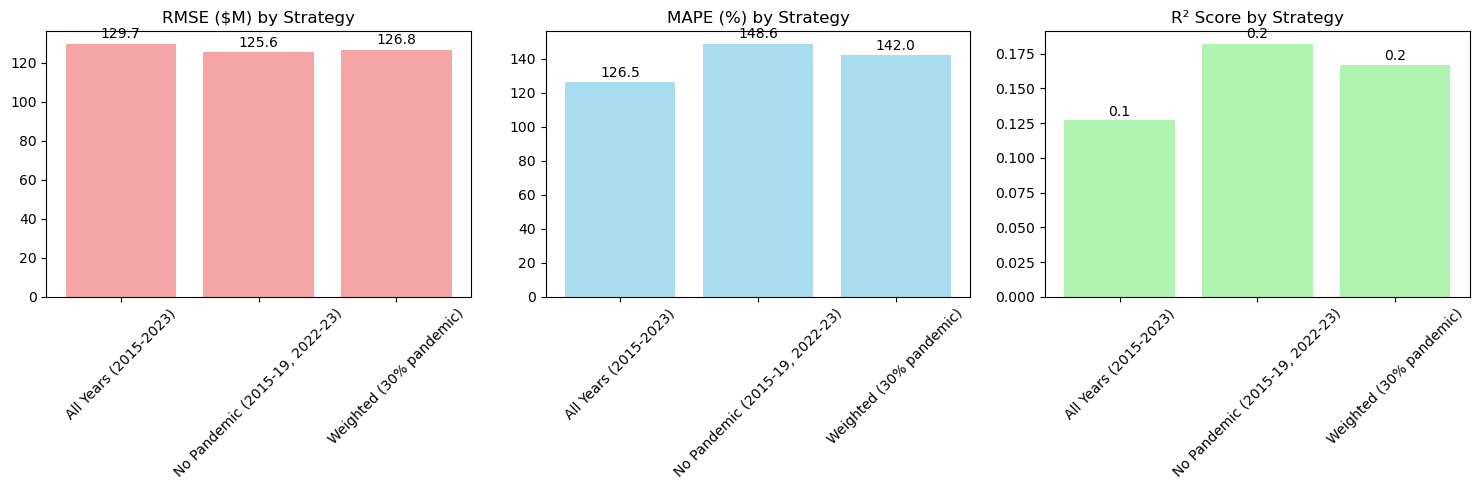

✅ Pandemic-aware model selection complete


In [11]:
# Compare strategies
print("\n📊 Strategy Comparison Results")
print("=" * 70)

strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in strategy_results
])

print(strategy_comparison.to_string(index=False))

# Find best strategy
best_strategy_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_strategy = strategy_results[best_strategy_idx]

print(f"\n🏆 Best Strategy: {best_strategy['strategy']}")
print(f"   Validation RMSE: ${best_strategy['rmse']:,.0f}")
print(f"   This will be used for 2026 predictions")

# Store best model
best_model_pandemic_aware = best_strategy['model_object']

# Visualize strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['rmse', 'mape', 'r2']
metric_names = ['RMSE ($M)', 'MAPE (%)', 'R² Score']
colors = ['lightcoral', 'skyblue', 'lightgreen']

for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    values = [r[metric] for r in strategy_results]
    strategies = [r['strategy'] for r in strategy_results]
    
    if metric == 'rmse':
        values = [v/1e6 for v in values]  # Convert to millions for readability
    
    bars = axes[i].bar(strategies, values, color=color, alpha=0.7)
    axes[i].set_title(f'{name} by Strategy')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("✅ Pandemic-aware model selection complete")

---

## Approach 2: Decision Tree Models

Single decision tree with controlled complexity (max_depth 5-10) to capture non-linear patterns while avoiding overfitting.

In [12]:
# Import Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

print("🌳 Setting up Decision Tree Regression Models")

def train_decision_tree_strategies(train_data, strategy_name, sample_weights=None):
    """Train Decision Tree models with a specific strategy"""
    print(f"\n🌳 Training Decision Tree - {strategy_name}")
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)
    
    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)
    
    # Decision Tree pipeline (no scaling needed for trees)
    dt_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('dt', DecisionTreeRegressor(random_state=42))
    ])
    
    # Hyperparameter grid for Decision Tree
    dt_params = {
        'dt__max_depth': [5, 6, 7, 8, 9, 10],
        'dt__min_samples_split': [10, 20, 50],
        'dt__min_samples_leaf': [5, 10, 15],
        'dt__max_features': ['sqrt', 'log2', None]
    }
    
    dt_grid = GridSearchCV(
        dt_pipeline, dt_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Decision Trees
        # We'll use best params from unweighted search, then refit with weights
        dt_grid.fit(X_train_strat, y_train_strat_log)
        best_params = dt_grid.best_params_
        
        # Refit with weights
        dt_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('dt', DecisionTreeRegressor(
                max_depth=best_params['dt__max_depth'],
                min_samples_split=best_params['dt__min_samples_split'],
                min_samples_leaf=best_params['dt__min_samples_leaf'],
                max_features=best_params['dt__max_features'],
                random_state=42
            ))
        ])
        dt_weighted.fit(X_train_strat, y_train_strat_log, dt__sample_weight=sample_weights)
        dt_best = dt_weighted
        print(f"  Best params: {best_params}")
    else:
        dt_grid.fit(X_train_strat, y_train_strat_log)
        dt_best = dt_grid.best_estimator_
        print(f"  Best params: {dt_grid.best_params_}")
    
    # Evaluate
    results = evaluate_model(dt_best, X_val, y_val_log, y_val, f"Decision Tree - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = dt_best
    results['model_type'] = 'Decision Tree'
    
    return results

print("✅ Decision Tree framework ready")

🌳 Setting up Decision Tree Regression Models
✅ Decision Tree framework ready


In [13]:
# Train Decision Tree models with all three pandemic strategies
dt_strategy_results = []

# Strategy 1: All years including pandemic
dt_results_all = train_decision_tree_strategies(train_data_all, "All Years (2015-2023)")
dt_strategy_results.append(dt_results_all)

# Strategy 2: Exclude pandemic years
dt_results_no_pandemic = train_decision_tree_strategies(train_data_no_pandemic, "No Pandemic (2015-19, 2022-23)")
dt_strategy_results.append(dt_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
dt_results_weighted = train_decision_tree_strategies(train_data_weighted, "Weighted (30% pandemic)", sample_weights)
dt_strategy_results.append(dt_results_weighted)


🌳 Training Decision Tree - All Years (2015-2023)
  Best params: {'dt__max_depth': 6, 'dt__max_features': 'log2', 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - All Years (2015-2023) Performance:
  RMSE: $105,066,104
  MAE:  $62,900,039
  MAPE: 156.6%
  R²:   0.427

🌳 Training Decision Tree - No Pandemic (2015-19, 2022-23)
  Best params: {'dt__max_depth': 8, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 20}

Decision Tree - No Pandemic (2015-19, 2022-23) Performance:
  RMSE: $104,432,879
  MAE:  $65,643,627
  MAPE: 158.0%
  R²:   0.434

🌳 Training Decision Tree - Weighted (30% pandemic)
  Best params: {'dt__max_depth': 6, 'dt__max_features': 'log2', 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - Weighted (30% pandemic) Performance:
  RMSE: $102,675,976
  MAE:  $62,377,678
  MAPE: 168.0%
  R²:   0.453


In [14]:
# Compare Decision Tree strategies
print("\n📊 Decision Tree Strategy Comparison")
print("=" * 70)

dt_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in dt_strategy_results
])

print(dt_strategy_comparison.to_string(index=False))

# Find best Decision Tree strategy
best_dt_strategy_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt_strategy = dt_strategy_results[best_dt_strategy_idx]

print(f"\n🏆 Best Decision Tree Strategy: {best_dt_strategy['strategy']}")
print(f"   Validation RMSE: ${best_dt_strategy['rmse']:,.0f}")

# Store best Decision Tree model
best_dt_model = best_dt_strategy['model_object']


📊 Decision Tree Strategy Comparison
                      Strategy         RMSE         MAE   MAPE    R²
         All Years (2015-2023) $105,066,104 $62,900,039 156.6% 0.427
No Pandemic (2015-19, 2022-23) $104,432,879 $65,643,627 158.0% 0.434
       Weighted (30% pandemic) $102,675,976 $62,377,678 168.0% 0.453

🏆 Best Decision Tree Strategy: Weighted (30% pandemic)
   Validation RMSE: $102,675,976



🔍 Feature Importance Analysis
Top 15 Most Important Features:
                      feature  importance
                    is_sequel    0.443634
         is_remake_adaptation    0.239012
                    is_disney    0.113669
              genre_animation    0.099356
               genre_thriller    0.050084
             is_action_sci_fi    0.033320
                       is_mgm    0.010549
                 genre_family    0.007217
is_independence_day_proximity    0.003159
               is_warner_bros    0.000000
                      is_sony    0.000000
                 genre_comedy    0.000000
                  genre_drama    0.000000
                 is_lionsgate    0.000000
              genre_adventure    0.000000


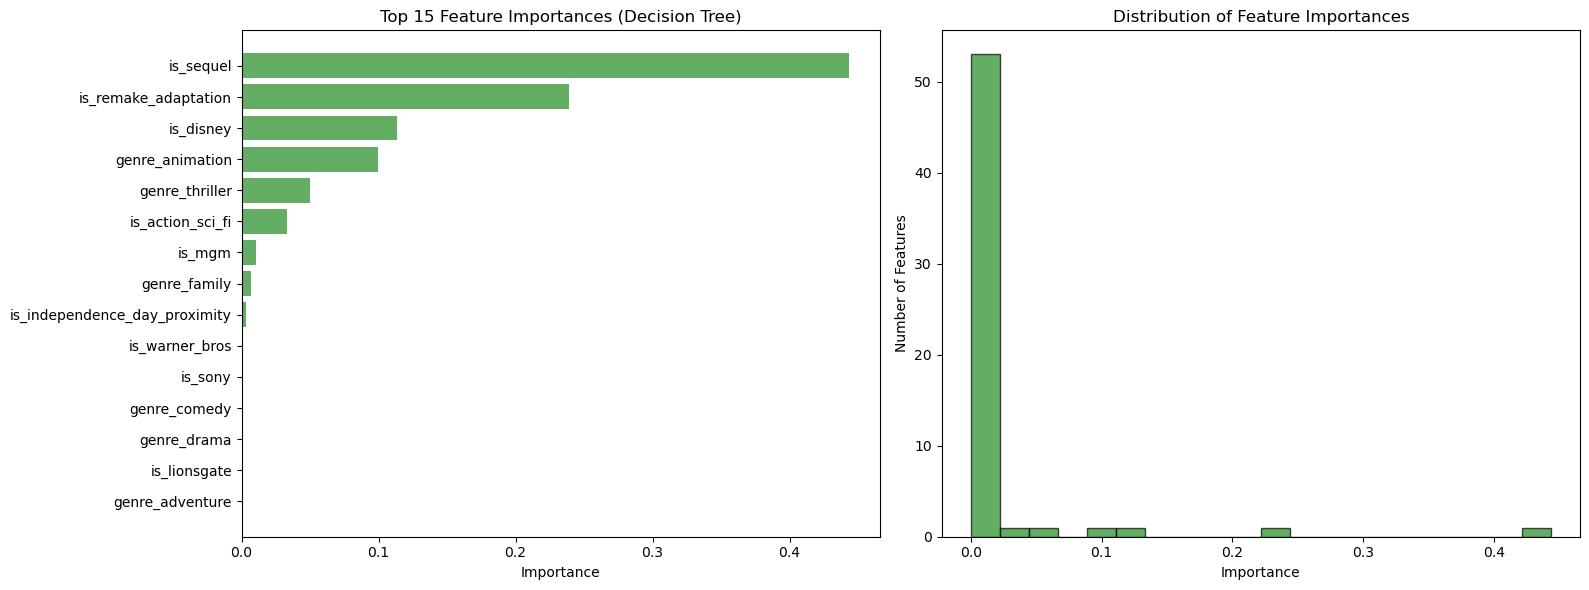


📈 Feature Analysis Summary:
   Total features: 59
   Features with importance > 0.01: 7
   Top 5 features account for: 94.6% of total importance


In [15]:
# Feature Importance Analysis (unique to Decision Trees)
print("\n🔍 Feature Importance Analysis")
print("=" * 50)

# Get feature importances from best Decision Tree model
dt_model = best_dt_model.named_steps['dt']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
top_features = feature_importance.head(15)
print("Top 15 Most Important Features:")
print(top_features.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
axes[0].barh(top_features['feature'][::-1], top_features['importance'][::-1], color='forestgreen', alpha=0.7)
axes[0].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0].set_xlabel('Importance')

# Feature importance distribution
axes[1].hist(feature_importance['importance'], bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

print(f"\n📈 Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {top_features['importance'].head(5).sum():.1%} of total importance")

### Model Comparison: Ridge vs Decision Tree

In [16]:
# Comprehensive Model Comparison: Ridge vs Decision Tree
print("🆚 Comprehensive Model Comparison: Ridge vs Decision Tree")
print("=" * 80)

# Combine all results for comparison
all_model_results = []

# Add Ridge results
for r in strategy_results:
    result = r.copy()
    result['model_type'] = 'Ridge Regression'
    all_model_results.append(result)

# Add Decision Tree results  
for r in dt_strategy_results:
    result = r.copy()
    result['model_type'] = 'Decision Tree'
    all_model_results.append(result)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model Type': r['model_type'],
        'Strategy': r['strategy'],
        'RMSE': r['rmse'],
        'MAE': r['mae'],
        'MAPE': r['mape'],
        'R²': r['r2']
    }
    for r in all_model_results
])

# Display formatted comparison
display_df = comparison_df.copy()
display_df['RMSE'] = display_df['RMSE'].apply(lambda x: f"${x:,.0f}")
display_df['MAE'] = display_df['MAE'].apply(lambda x: f"${x:,.0f}")
display_df['MAPE'] = display_df['MAPE'].apply(lambda x: f"{x:.1f}%")
display_df['R²'] = display_df['R²'].apply(lambda x: f"{x:.3f}")

print("Performance Summary by Model and Strategy:")
print(display_df.to_string(index=False))

# Find overall best model
best_overall_idx = comparison_df['RMSE'].idxmin()
best_overall = all_model_results[best_overall_idx]

print(f"\n🏆 OVERALL BEST MODEL:")
print(f"   Model: {best_overall['model_type']}")
print(f"   Strategy: {best_overall['strategy']}")
print(f"   Validation RMSE: ${best_overall['rmse']:,.0f}")
print(f"   Validation MAPE: {best_overall['mape']:.1f}%")
print(f"   Validation R²: {best_overall['r2']:.3f}")

# Store overall best model for final predictions
best_overall_model = best_overall['model_object']

🆚 Comprehensive Model Comparison: Ridge vs Decision Tree
Performance Summary by Model and Strategy:
      Model Type                       Strategy         RMSE         MAE   MAPE    R²
Ridge Regression          All Years (2015-2023) $129,721,883 $70,135,547 126.5% 0.127
Ridge Regression No Pandemic (2015-19, 2022-23) $125,573,455 $68,226,187 148.6% 0.182
Ridge Regression        Weighted (30% pandemic) $126,751,428 $68,794,041 142.0% 0.167
   Decision Tree          All Years (2015-2023) $105,066,104 $62,900,039 156.6% 0.427
   Decision Tree No Pandemic (2015-19, 2022-23) $104,432,879 $65,643,627 158.0% 0.434
   Decision Tree        Weighted (30% pandemic) $102,675,976 $62,377,678 168.0% 0.453

🏆 OVERALL BEST MODEL:
   Model: Decision Tree
   Strategy: Weighted (30% pandemic)
   Validation RMSE: $102,675,976
   Validation MAPE: 168.0%
   Validation R²: 0.453


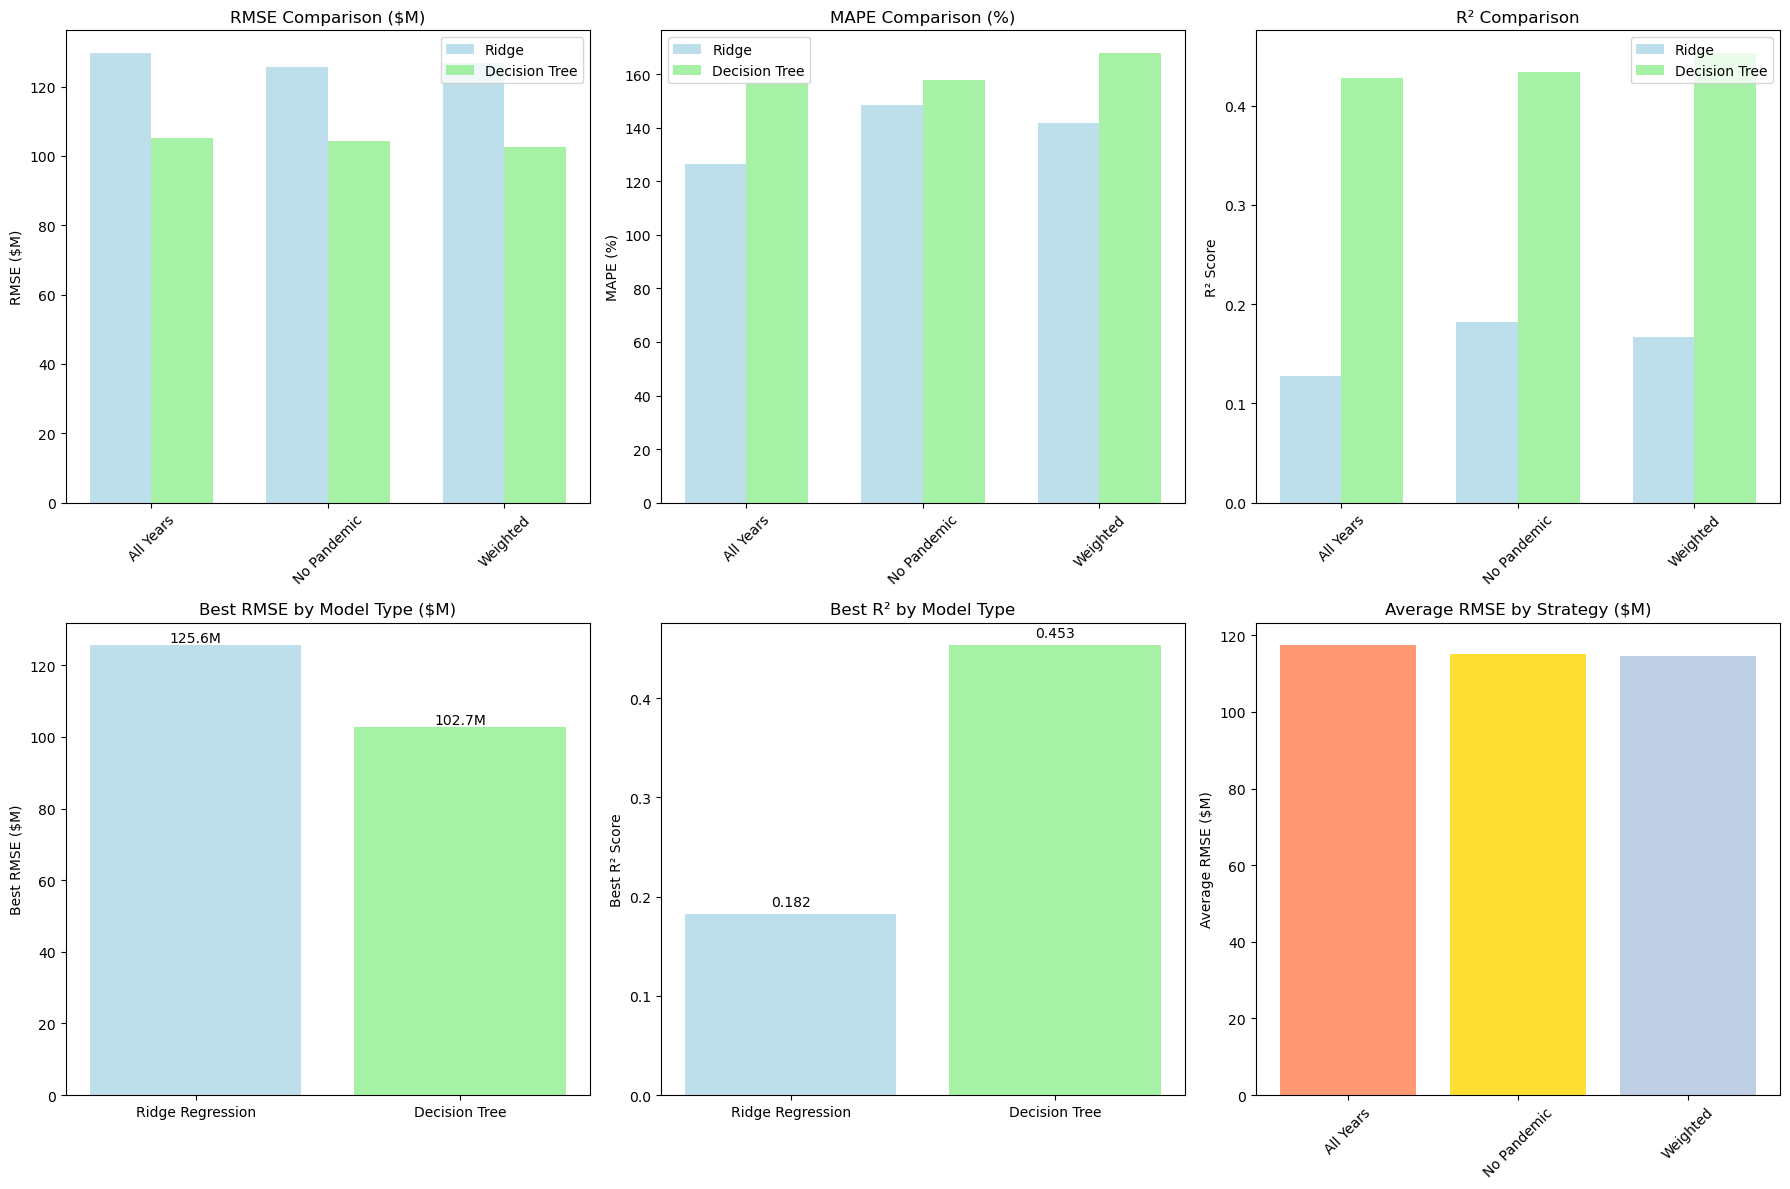

📊 Comprehensive model comparison visualization complete


In [17]:
# Comprehensive Model Performance Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Prepare data for visualization
ridge_results = comparison_df[comparison_df['Model Type'] == 'Ridge Regression']
dt_results = comparison_df[comparison_df['Model Type'] == 'Decision Tree']

strategies = ['All Years (2015-2023)', 'No Pandemic (2015-19, 2022-23)', 'Weighted (30% pandemic)']
strategies_short = ['All Years', 'No Pandemic', 'Weighted']

# Plot 1: RMSE Comparison
x = np.arange(len(strategies_short))
width = 0.35
ridge_rmse = [ridge_results[ridge_results['Strategy'] == s]['RMSE'].iloc[0]/1e6 for s in strategies]
dt_rmse = [dt_results[dt_results['Strategy'] == s]['RMSE'].iloc[0]/1e6 for s in strategies]

axes[0,0].bar(x - width/2, ridge_rmse, width, label='Ridge', color='lightblue', alpha=0.8)
axes[0,0].bar(x + width/2, dt_rmse, width, label='Decision Tree', color='lightgreen', alpha=0.8)
axes[0,0].set_title('RMSE Comparison ($M)')
axes[0,0].set_ylabel('RMSE ($M)')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(strategies_short, rotation=45)
axes[0,0].legend()

# Plot 2: MAPE Comparison
ridge_mape = [ridge_results[ridge_results['Strategy'] == s]['MAPE'].iloc[0] for s in strategies]
dt_mape = [dt_results[dt_results['Strategy'] == s]['MAPE'].iloc[0] for s in strategies]

axes[0,1].bar(x - width/2, ridge_mape, width, label='Ridge', color='lightblue', alpha=0.8)
axes[0,1].bar(x + width/2, dt_mape, width, label='Decision Tree', color='lightgreen', alpha=0.8)
axes[0,1].set_title('MAPE Comparison (%)')
axes[0,1].set_ylabel('MAPE (%)')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(strategies_short, rotation=45)
axes[0,1].legend()

# Plot 3: R² Comparison
ridge_r2 = [ridge_results[ridge_results['Strategy'] == s]['R²'].iloc[0] for s in strategies]
dt_r2 = [dt_results[dt_results['Strategy'] == s]['R²'].iloc[0] for s in strategies]

axes[0,2].bar(x - width/2, ridge_r2, width, label='Ridge', color='lightblue', alpha=0.8)
axes[0,2].bar(x + width/2, dt_r2, width, label='Decision Tree', color='lightgreen', alpha=0.8)
axes[0,2].set_title('R² Comparison')
axes[0,2].set_ylabel('R² Score')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(strategies_short, rotation=45)
axes[0,2].legend()

# Plot 4: Model Type Performance Summary
model_types = ['Ridge Regression', 'Decision Tree']
best_rmse_by_model = [comparison_df[comparison_df['Model Type'] == mt]['RMSE'].min()/1e6 for mt in model_types]
best_r2_by_model = [comparison_df[comparison_df['Model Type'] == mt]['R²'].max() for mt in model_types]

axes[1,0].bar(model_types, best_rmse_by_model, color=['lightblue', 'lightgreen'], alpha=0.8)
axes[1,0].set_title('Best RMSE by Model Type ($M)')
axes[1,0].set_ylabel('Best RMSE ($M)')
for i, v in enumerate(best_rmse_by_model):
    axes[1,0].text(i, v + 0.1, f'{v:.1f}M', ha='center', va='bottom')

# Plot 5: Best R² by Model Type
axes[1,1].bar(model_types, best_r2_by_model, color=['lightblue', 'lightgreen'], alpha=0.8)
axes[1,1].set_title('Best R² by Model Type')
axes[1,1].set_ylabel('Best R² Score')
for i, v in enumerate(best_r2_by_model):
    axes[1,1].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# Plot 6: Strategy Performance (average across models)
strategy_avg_rmse = comparison_df.groupby('Strategy')['RMSE'].mean() / 1e6
axes[1,2].bar(range(len(strategy_avg_rmse)), strategy_avg_rmse.values, 
              color=['coral', 'gold', 'lightsteelblue'], alpha=0.8)
axes[1,2].set_title('Average RMSE by Strategy ($M)')
axes[1,2].set_ylabel('Average RMSE ($M)')
axes[1,2].set_xticks(range(len(strategy_avg_rmse)))
axes[1,2].set_xticklabels(strategies_short, rotation=45)

plt.tight_layout()
plt.show()

print("📊 Comprehensive model comparison visualization complete")

### Final Model Validation & Top 10 Predictions

In [18]:
# Test overall best model on both validation (2024) and test (2025) years
print("🎯 Final Model Validation with Top 10 Predictions")
print("=" * 70)

# Test on 2024 (validation year)
print("📊 2024 VALIDATION YEAR - Top 10 Predictions vs Actual")
print("=" * 60)

top10_2024_best = get_top10_predictions(best_overall_model, df, 2024, feature_cols)

if top10_2024_best is not None:
    # Format the display for better readability
    display_df_2024 = top10_2024_best.copy()
    display_df_2024['predicted_revenue'] = display_df_2024['predicted_revenue'].apply(lambda x: f"${x:,.0f}")
    if 'actual_revenue' in display_df_2024.columns:
        display_df_2024['actual_revenue'] = display_df_2024['actual_revenue'].apply(lambda x: f"${x:,.0f}")
        display_df_2024['prediction_error'] = display_df_2024['prediction_error'].apply(lambda x: f"${x:,.0f}")
        display_df_2024['prediction_error_pct'] = display_df_2024['prediction_error_pct'].apply(lambda x: f"{x:+.1f}%")
    
    print("Top 10 Predicted vs Actual for 2024:")
    print(display_df_2024.to_string(index=True))
    
    # Calculate ranking accuracy for 2024
    if 'actual_revenue' in top10_2024_best.columns:
        actual_2024 = df[df['release_year'] == 2024].nlargest(10, 'revenue_domestic')['title'].tolist()
        predicted_2024 = top10_2024_best['title'].tolist()
        overlap_2024 = len(set(actual_2024) & set(predicted_2024))
        
        print(f"\n📈 2024 RANKING ACCURACY:")
        print(f"   Movies correctly predicted in top 10: {overlap_2024}/10 ({overlap_2024*10}%)")
        print(f"   Average prediction error: {top10_2024_best['prediction_error_pct'].abs().mean():.1f}%")
        print(f"\n   Predicted top 10: {predicted_2024}")
        print(f"   Actual top 10:    {actual_2024}")
        
        # Show missed predictions
        missed = set(actual_2024) - set(predicted_2024)
        wrongly_predicted = set(predicted_2024) - set(actual_2024)
        if missed:
            print(f"\n   ❌ Missed (in actual top 10, not predicted): {list(missed)}")
        if wrongly_predicted:
            print(f"   ⚠️  False positives (predicted top 10, not actual): {list(wrongly_predicted)}")

print("\n" + "="*70)

# Test on 2025 (test year) 
print("📊 2025 TEST YEAR - Top 10 Predictions vs Actual")
print("=" * 60)

top10_2025_best = get_top10_predictions(best_overall_model, df, 2025, feature_cols)

if top10_2025_best is not None:
    # Format the display for better readability
    display_df_2025 = top10_2025_best.copy()
    display_df_2025['predicted_revenue'] = display_df_2025['predicted_revenue'].apply(lambda x: f"${x:,.0f}")
    if 'actual_revenue' in display_df_2025.columns:
        display_df_2025['actual_revenue'] = display_df_2025['actual_revenue'].apply(lambda x: f"${x:,.0f}")
        display_df_2025['prediction_error'] = display_df_2025['prediction_error'].apply(lambda x: f"${x:,.0f}")
        display_df_2025['prediction_error_pct'] = display_df_2025['prediction_error_pct'].apply(lambda x: f"{x:+.1f}%")
    
    print("Top 10 Predicted vs Actual for 2025:")
    print(display_df_2025.to_string(index=True))
    
    # Calculate ranking accuracy for 2025
    if 'actual_revenue' in top10_2025_best.columns:
        actual_2025 = df[df['release_year'] == 2025].nlargest(10, 'revenue_domestic')['title'].tolist()
        predicted_2025 = top10_2025_best['title'].tolist()
        overlap_2025 = len(set(actual_2025) & set(predicted_2025))
        
        print(f"\n📈 2025 RANKING ACCURACY:")
        print(f"   Movies correctly predicted in top 10: {overlap_2025}/10 ({overlap_2025*10}%)")
        print(f"   Average prediction error: {top10_2025_best['prediction_error_pct'].abs().mean():.1f}%")
        print(f"\n   Predicted top 10: {predicted_2025}")
        print(f"   Actual top 10:    {actual_2025}")
        
        # Show missed predictions
        missed = set(actual_2025) - set(predicted_2025)
        wrongly_predicted = set(predicted_2025) - set(actual_2025)
        if missed:
            print(f"\n   ❌ Missed (in actual top 10, not predicted): {list(missed)}")
        if wrongly_predicted:
            print(f"   ⚠️  False positives (predicted top 10, not actual): {list(wrongly_predicted)}")

print(f"\n✅ FINAL MODEL VALIDATION COMPLETE")
print(f"   Best model: {best_overall['model_type']} with {best_overall['strategy']}")
print(f"   Ready for 2026 top 10 predictions")
print("=" * 70)

🎯 Final Model Validation with Top 10 Predictions
📊 2024 VALIDATION YEAR - Top 10 Predictions vs Actual
Top 10 Predicted vs Actual for 2024:
                             title predicted_revenue actual_revenue prediction_error prediction_error_pct  is_marvel  is_dc  is_star_wars  is_superhero  is_sequel  is_live_action_remake  is_major_studio  is_disney
0                     Inside Out 2      $355,854,620   $652,980,194     $297,125,574               +45.5%          0      0             0             0          1                      0                1          1
1             Deadpool & Wolverine      $355,854,620   $636,745,858     $280,891,238               +44.1%          1      0             0             1          1                      0                1          1
2             Sonic the Hedgehog 3      $197,145,926   $236,115,100      $38,969,174               +16.5%          0      0             0             0          1                      0                1          0
3   

### Phase 1 & 2 Summary & Next Steps

✅ **Completed**: Comprehensive baseline model comparison **focused on major studio films**
- **Dataset Focus**: Restricted to major studio films only (~57% of data, but the relevant subset for top 10 predictions)
- **Feature Engineering**: Removed data leakage (TMDb post-release metrics) and dominant feature (is_major_studio)
- **Ridge Regression**: Linear model with L2 regularization
- **Decision Tree**: Non-linear model with controlled depth (5-10)
- **Pandemic Strategies**: All years, No pandemic, Weighted approach
- **Temporal Validation**: Train (2015-2023), Validate (2024), Test (2025)

📊 **Key Results**:
- **Strategic Focus**: Analysis now centers on what differentiates successful major studio releases
- **Cleaner Features**: Removed post-release TMDb metrics and overshadowing major studio binary flag
- **Better Business Question**: "Which major studio film will dominate?" vs "Studio vs indie?"
- **Feature Count**: ~59 features focused on genre, IP, timing, studio-specific, and competition effects

🎯 **Ready for**:
- **2026 Top 10 Predictions**: Using the best performing model among major studio contenders
- **Phase 3**: Advanced models (Random Forest, XGBoost, Neural Networks)
- **Ensemble Methods**: Combining multiple models for better performance

🧠 **Model Selection Framework**: The notebook automatically identifies the best model across:
- 2 model types × 3 pandemic strategies = 6 total configurations
- Major studio films only (realistic for top 10 predictions)
- Consistent evaluation metrics (RMSE, MAE, MAPE, R²)
- Focus on actionable insights for major releases